In [25]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
# used chatGPT

In [26]:
# Load features and labels
features_array = np.load('x_data.npy', allow_pickle=True)
labels_array = np.load('y_label.npy', allow_pickle=True)


In [27]:
columns_to_remove = [
 'font_size', 'right_gaze_point_in_user_x', 'left_gaze_point_in_user_z', 
'left_gaze_point_on_display_area_y', 'right_gaze_point_on_display_area_x', 
'right_gaze_point_in_user_z', 'right_gaze_point_in_user_y', 
 'left_gaze_point_in_user_x', 'right_pupil_diameter', 
 'left_gaze_origin_in_trackbox_z', 'right_gaze_origin_in_trackbox_y', 
 'left_gaze_origin_in_trackbox_x', 'right_gaze_origin_in_user_z', 
 'left_gaze_origin_in_user_x', 'left_gaze_origin_in_user_y', 
 'left_gaze_origin_validity', 'right_gaze_origin_validity', 
 'device_time_stamp', 'left_gaze_point_validity', 
 'right_gaze_point_validity', 'left_pupil_validity', 'right_pupil_validity'
]


In [28]:
processed_dataframes = []
for df in features_array:
  #Drop the columns if they exist, ignore errors if some columns don't exist
  new_df = df.drop(columns=columns_to_remove, errors='ignore')
  processed_dataframes.append(new_df)

features_array = np.array(processed_dataframes, dtype=object)

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

lengths = [df.size for df in features_array]
k = int(np.median(lengths))
# Example of handling non-numeric data before flattening
processed_features = []
encoder = OneHotEncoder(sparse=False)  # Initialize one-hot encoder

for df in features_array:
    # Check and transform non-numeric columns if necessary
    for col in df.columns:
        if df[col].dtype == object:
            # Assuming the non-numeric data is categorical and not text like 'Times New Roman'
            transformed = encoder.fit_transform(df[[col]])
            df = pd.concat([df.drop(col, axis=1), pd.DataFrame(transformed)], axis=1)
    
    # Flatten and standardize lengths as before
    flattened = df.values.flatten()
    # Use a fixed length 'k' determined as before
    if len(flattened) > k:
        processed_features.append(flattened[:k])
    else:
        processed_features.append(np.pad(flattened, (0, k - len(flattened)), 'constant'))

X = np.array(processed_features)
y = labels_array

In [30]:
print("NaNs in X:", np.isnan(X).any())
print("Infs in X:", np.isinf(X).any())

# If there are any, you might want to consider replacing them
if np.isnan(X).any() or np.isinf(X).any():
    # Replace NaNs with the mean of the column
    col_mean = np.nanmean(X, axis=0)  # Mean ignoring NaNs
    # Find indices where NaN values are
    inds = np.where(np.isnan(X))
    # Replace NaNs with the mean of each column
    X[inds] = np.take(col_mean, inds[1])

    # Replace infinities with large finite numbers
    X[np.isinf(X)] = 1e+18  # You might choose a suitable finite number

    # Re-check
    print("NaNs in X after replacement:", np.isnan(X).any())
    print("Infs in X after replacement:", np.isinf(X).any())


NaNs in X: True
Infs in X: False
NaNs in X after replacement: False
Infs in X after replacement: False


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [32]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Fit and transform the labels to integers
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Save the encoder if you need to decode labels later
import joblib
joblib.dump(encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [33]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)  # Now y_train_encoded contains integers
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [34]:
# Example reshape, adjust depending on your specific needs and data properties

X_train_reshaped = X_train.reshape(-1, 1, 89, 91)  # -1 for batch size, 1 for channel, 89x91 as an example shape
X_test_reshaped = X_test.reshape(-1, 1, 89, 91)

# Convert reshaped data to tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)

# Re-create your DataLoader with the reshaped data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [35]:
# Calculate total elements and intended product from reshape dimensions
total_elements = X_train.size
intended_product = 1 * 89*2 * 117
num_intended_samples = total_elements / intended_product

print(f"Total elements in X_train: {total_elements}")
print(f"Expected samples after reshape: {num_intended_samples}")
print(f"Actual number of labels: {y_train_tensor.shape[0]}")


Total elements in X_train: 7953218
Expected samples after reshape: 381.8888888888889
Actual number of labels: 982


In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(15488, 128)  # Update this to match the flattened output size 15488
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
model = CNN()
lossarr = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define the training loop
def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        lossarr.append(loss.item())

# Train the model
train_model(15)  # Adjust the number of epochs as needed


Epoch 1, Loss: 1.6082491874694824
Epoch 2, Loss: 1.730913519859314
Epoch 3, Loss: 1.2696210145950317
Epoch 4, Loss: 1.3106739521026611
Epoch 5, Loss: 1.3224395513534546
Epoch 6, Loss: 1.3662718534469604
Epoch 7, Loss: 1.4018046855926514
Epoch 8, Loss: 1.3384850025177002
Epoch 9, Loss: 1.483262538909912
Epoch 10, Loss: 1.7616524696350098
Epoch 11, Loss: 1.626878261566162
Epoch 12, Loss: 1.0023702383041382
Epoch 13, Loss: 1.3509609699249268
Epoch 14, Loss: 1.6084601879119873
Epoch 15, Loss: 1.2078944444656372


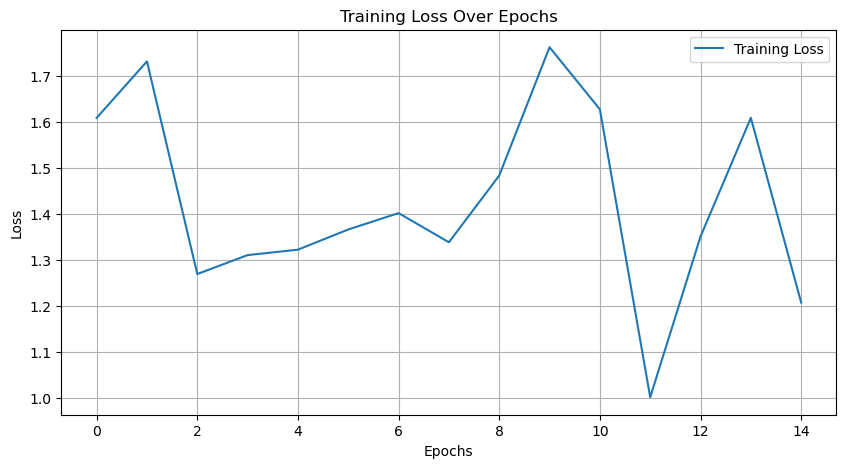

In [38]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(lossarr, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')



Accuracy of the model on the test images: 36.17886178861789%


In [40]:
class DenseNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(DenseNetwork, self).__init__()
        self.layers = nn.Sequential()  # Use Sequential for simpler architecture definition

        # Adding the first layer
        self.layers.add_module("linear_0", nn.Linear(input_size, hidden_layers[0]))
        self.layers.add_module("relu_0", nn.ReLU())

        # Adding subsequent hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.add_module(f"linear_{i}", nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.add_module(f"relu_{i}", nn.ReLU())

        # Adding the output layer
        self.layers.add_module("output", nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Ensure input is flattened
        return self.layers(x)


In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Initialize the Dense Network
# Assuming the shape of each data sample in X_train_reshaped is (1, 89, 91)
input_size = 1 * 89 * 91  # Calculate the total number of features after flattening
model = DenseNetwork(input_size, [256, 128], 10)  # Now the input size should be correct

lossarr2 = []
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):  # Define num_epochs as per your training configuration
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    lossarr2.append(loss.item())


Epoch 1, Loss: 37.17522430419922
Epoch 2, Loss: 3.2102086544036865
Epoch 3, Loss: 21.767850875854492
Epoch 4, Loss: 29.795482635498047
Epoch 5, Loss: 11.019767761230469
Epoch 6, Loss: 6.086557388305664
Epoch 7, Loss: 1.7120190858840942
Epoch 8, Loss: 10.00841999053955
Epoch 9, Loss: 5.704995632171631
Epoch 10, Loss: 2.179039239883423
Epoch 11, Loss: 1.5101189613342285
Epoch 12, Loss: 1.7332885265350342
Epoch 13, Loss: 1.8311198949813843
Epoch 14, Loss: 1.7171638011932373
Epoch 15, Loss: 1.7326385974884033
Epoch 16, Loss: 2.0927419662475586
Epoch 17, Loss: 1.9532349109649658
Epoch 18, Loss: 1.4373563528060913
Epoch 19, Loss: 2.3509790897369385
Epoch 20, Loss: 1.6792279481887817
Epoch 21, Loss: 1.4316353797912598
Epoch 22, Loss: 1.5577915906906128
Epoch 23, Loss: 2.5921928882598877
Epoch 24, Loss: 1.2576771974563599
Epoch 25, Loss: 1.0770131349563599
Epoch 26, Loss: 1.0471556186676025
Epoch 27, Loss: 1.0864900350570679
Epoch 28, Loss: 1.5983214378356934
Epoch 29, Loss: 1.0894640684127808

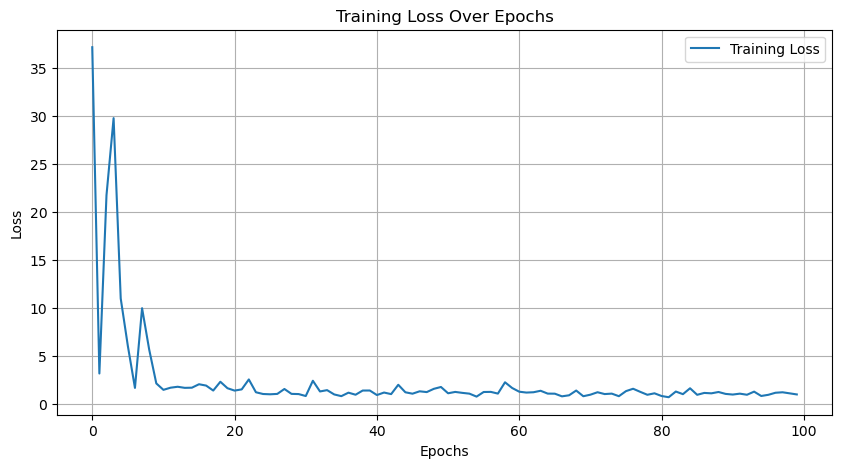

In [42]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(lossarr2, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 44.3089430894309%


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



# Flatten the data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=250,  # Number of trees in the forest
                                  random_state=224182,   # Seed for reproducibility
                                  n_jobs=-1)         # Use all available cores

# Train the model on the flattened data
rf_model.fit(X_train_flattened, y_train)

# Predict on the test set using the flattened test data
y_pred = rf_model.predict(X_test_flattened)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

#make confusion matrix!

Accuracy: 0.5691056910569106
                        precision    recall  f1-score   support

      immersive - easy       0.50      0.25      0.33         4
      immersive - hard       1.00      0.29      0.44         7
    immersive - normal       0.80      0.57      0.67         7
       skimming - easy       0.58      0.39      0.47        64
       skimming - hard       0.71      0.51      0.60        72
     skimming - normal       0.50      0.78      0.61        88
skimming - really hard       0.50      0.50      0.50         4

              accuracy                           0.57       246
             macro avg       0.66      0.47      0.52       246
          weighted avg       0.61      0.57      0.56       246



In [45]:
#import xgboost as xgb
#from sklearn.metrics import classification_report, accuracy_score

#from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
#label_encoder = LabelEncoder()

# Fit label encoder and transform the target variable
#y_train_encoded = label_encoder.fit_transform(y_train)

# Now, y_train_encoded will contain numerical labels instead of strings
# You can use these encoded labels to fit your XGBoost classifier



# Configure XGBoost as a Random Forest
#xgb_rf = xgb.XGBClassifier(
 #   n_estimators=100,          # Number of trees to train
 #   num_parallel_tree=100,     # Number of trees to use in parallel (same as n_estimators)
 #   subsample=1.0,             # Use all data for training each tree
 #   colsample_bytree=0.8,      # Fraction of features to use for each tree
 #   max_depth=6,               # Depth of each tree
   # booster='gbtree',          # Tree booster
  #  objective='multi:softmax', # Objective function for multi-class classification
  #  use_label_encoder=False,   # Handle deprecation warning for label encoding
  #  eval_metric='mlogloss',    # Metric for multi-class classification
 #   random_state=42            # Seed for reproducibility
#)

# Assuming X_train_flattened and y_train are already defined and suitable for training
#xgb_rf.fit(X_train_flattened, y_train_encoded)

# Predict on the test set
#y_pred = xgb_rf.predict(X_test_flattened)

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)
#print(classification_report(y_test, y_pred))


In [46]:
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels_array)
label_counts

Counter({'immersive - normal': 53,
         'immersive - easy': 27,
         'immersive - hard': 34,
         'skimming - normal': 450,
         'skimming - easy': 278,
         'skimming - hard': 360,
         'immersive - really hard': 2,
         'skimming - really hard': 24})

In [47]:
450/len(labels_array)

0.36644951140065146